In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To introduce Support Vector Machines we'll start with the simplest example: linear support vector binary classifiers. This modeling technique will provide decent performance as well as a solid gateway into more advanced SVM techniques.

Let's look at some data that we might want to classify. Imagine you've got some data from a course about test scores, project scores, and whether the student passed or failed the course.

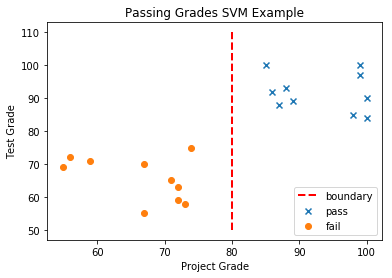

In [4]:
# Example data.
test_data = pd.DataFrame()

test_data['test'] = [90, 100, 85, 93, 88, 100, 97, 92, 89, 84,
                     55, 65, 75, 58, 69, 71, 72, 63, 70, 59]
test_data['project'] = [100, 85, 98, 88, 87, 99, 99, 86, 89, 100,
                        67, 71, 74, 73, 55, 59, 56, 72, 67, 72]
test_data['pass'] = ['pass', 'pass', 'pass', 'pass', 'pass',
                     'pass', 'pass', 'pass', 'pass', 'pass',
                     'fail', 'fail', 'fail', 'fail', 'fail',
                     'fail', 'fail', 'fail', 'fail', 'fail']

# Reusable function to plot our data.
def setup_plot():
    plt.scatter(test_data.project[0:10], test_data.test[0:10], marker='x')
    plt.scatter(test_data.project[10:20], test_data.test[10:20], marker='o')

    # We'll eyeball a pass / fail line to split the points.
    plt.plot([80, 80], [50, 110], 'r--', lw=2)

    plt.xlabel('Project Grade')
    plt.ylabel('Test Grade')

setup_plot()
plt.legend(['boundary', 'pass', 'fail'], loc=4)
plt.title('Passing Grades SVM Example')
plt.show()
    

In the plot above we eyeballed a straight line decision **boundary** between the pass and fail data points. But is this the _best possible_ boundary line for making predictions? Here are some other options.

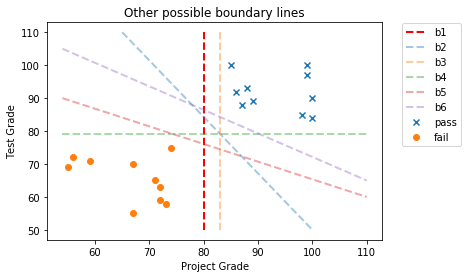

In [5]:
# Throw some other possible boundary lines into the mix.

# Rebuild the previous plot.
setup_plot()

# Add some new boundary lines.
plt.plot([65, 100], [110, 50], '--', lw=2, alpha=0.4)
plt.plot([83, 83], [110, 50], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [79, 79], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [90, 60], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [105, 65], '--', lw=2, alpha=0.4)

plt.legend(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'pass', 'fail'],
            bbox_to_anchor=(0.25, 0.02, 1, 1))
plt.title('Other possible boundary lines')
plt.show()

Are any of these new boundary lines better than our first attempt? Which color looks best to you? Why?

## Margin and Support Vectors

You probably have an intuition that a boundary line passing close to data points is bad because it'll be susceptable to noise and be worse at predicting new data points than a boundary line farther away. In SVM we formalize that intuition by defining the **margin** as the distance between the nearest point of each class and the boundary.

Finding the margin for our initial red boundary line is easy. The nearest point for each class is at (85,100) and (74,75). These nearest points are the **support vectors** that our model is named after. The distance from our support vectors to the red boundary line is just the horizontal distance (because our boundary happens to be vertical). The margin is 5 from the pass support vector and 6 from the fail support vector.

https://brilliant.org/wiki/dot-product-distance-between-point-and-a-line/

Is that the best we can do? No. Several of the other boundary lines are worse, like the orange boundary line `b3`, but looking at the light blue boundary line `b2` above you can probably see without having to do the math that the margin is larger so it's a _better_ boundary than our initial red boundary. The goal of SVM is find the _best_ boundary, or the boundary that optimizes the margin.


## Finding the optimal boundary

Let's fire it up, using SKLearn to find the actual optimal boundary line. We're doing a linear SVM example, so we'll force the boundary to be linear. To do this we'll use SVC with a linear kernel. We'll get into what that is and other options later. The "C" in `SVC` here stands for "classifier".

In [11]:
from sklearn.svm import SVC

# Instantiate our model and fit the data.
X = test_data[['test', 'project']]
Y = test_data['pass']
svm = SVC(kernel = 'linear')
svm.fit(X, Y)



3

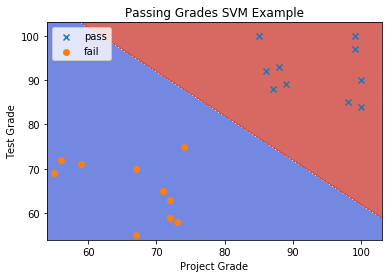

In [9]:
# Visualize our model
y_min, y_max = X.test.min() - 1, X.test.max() + 3
x_min, x_max = X.project.min() - 1, X.project.max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

Z = (svm.predict(np.c_[xx.ravel(), yy.ravel()])=='pass')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(test_data.project[0:10], test_data.test[0:10], marker='x', label="pass")
plt.scatter(test_data.project[10:20], test_data.test[10:20], marker='o', label = "fail")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Project Grade')
plt.ylabel('Test Grade')
plt.title('Passing Grades SVM Example')
plt.legend()
plt.show()

That looks pretty much as we'd expect. We can see a nice clear division between the two classes with a maximum distance between the support vectors and the decision boundary. High five ✋

## Things Get Messy

Now this is a nice example, but there are several things about it that are far simpler than anything you're likely to run into in the wild.

This dataset is in two dimensions, but SVM works in as many dimensions as you'd like (given the limitations of your computing resources). The boundary between two groups is therefore not always a line. A line is simply the way to represent this boundary in two dimensions. In general terms, the boundary is always a "hyperplane".

![Not actually a hyperplane](assets/hyperdrive.jpg)

No, that's hyper_drive_.

A **hyperplane** in n-dimensional space is _an n-minus-one-dimensional space_. So for a 2-dimensional plane like this one, a hyperplane is a 1-dimesional line. In 3-dimensional space the hyperplane is a 2-dimensional plane. In 4-dimensional spacetime a hyperplane is a 3-dimensional space. It gets tricky to visualize from here, but the concept continues in any number of dimensions.

Also of note is that this dataset has a boundary that groups each observation exclusively on one side of the line. This is called a _hard margin_. It won't always be possible to make a boundary with a hard margin, however. When it's not, the problem is called _soft margin_ (these two terms apply to all classifiers, by the way).

To deal with this kind of problem, SVM imposes a cost function. The cost function gives SVM two things to balance: the size of the margin (which it wants to maximize) and the cumulative distance of points on the wrong side of the margin from the boundary (which it wants to minimize).

How SVM balances these factors is complex and understanding the vector math behind it is not essential. What _is_ important to know is that you can control the priorities of this tradeoff by controlling that weight. How you'd want to tune it depends on your tolerance for inaccurate results as compared to large margins.